In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pickle as pkl
import os, sys
import numpy as np
from os import listdir
from os.path import isfile, join
import pickle as pkl
sys.path.append("../DetResponse/")
sys.path.append("../Utils/")
sys.path.append("../PDFs/")

from Detector import *
from Plot_Histogram import *
from Signal import *


In [59]:
# Grouping true energy:
nutype = 'nu_mu'
pid = 2
# path = './PreComp/EtrueSplitted/testbw/'
path = './PreComp/EtrueSplitted/'


# onlyfiles = [f for f in listdir(path) if (isfile(join(path, f)) and 'nu_e' in f and str(pid) in f) ]

In [60]:
Etrue = np.array([])
for i in range(0, 99, 2):
    firstE = i
    lastE = i+1
    # file = '{}RespMatrix_kde_bwadaptive_{}_pid{}_Ebin_{}_{}_weightbwFalse.pkl'.format(path, nutype, pid, firstE, lastE)
    file = '{}RespMatrix_kde_bwadaptive_{}_pid{}_Ebin_{}_{}.pkl'.format(path, nutype, pid, firstE, lastE)

    if not isfile(file):
        print("missing: {}".format(file))
        continue
    pkldict = pkl.load(open(file, "rb"))
    Resp = pkldict['Resp'][pid][nutype]
    Etrue = np.append(Etrue, pkldict['Bin']['true_energy_center'])
    if i==0:
        Resp_all = Resp 
    else:
        Resp_all = np.concatenate((Resp_all, Resp), axis=1)

In [5]:
Etrue.shape

(100,)

In [6]:
Resp_all.shape

(50, 100, 18, 50)

In [61]:
grid = dict()
grid['true_energy_center'] = Etrue
grid['true_psi_center'] = pkldict['Bin']['true_psi_center']
grid['reco_energy_center'] = pkldict['Bin']['reco_energy_center']
grid['reco_psi_center'] = pkldict['Bin']['reco_psi_center']


In [62]:
# mass and channel
mass = 1000
channel = 'bb'
# E true
Etrue_center = np.linspace(1., mass, 100)
Ewidth = (mass-1.)/(100.-1.)
Etrue_edges = [E - Ewidth/2. for E in Etrue_center]
Etrue_edges.append(Etrue_center[-1] + Ewidth/2.)
# Psi true
Psitrue_edges = np.linspace(0, 180, 51)
Psiwidth = 180./50.
Psitrue_center = np.array([Psitrue_edges[i]+Psiwidth/2. for i in range(len(Psitrue_edges)-1)])
# E reco
Ereco_edges = pow(10., np.linspace(np.log10(1.), np.log10(1e3), 50+1))
Ereco_center = np.array([np.sqrt(Ereco_edges[i]*Ereco_edges[i+1]) for i in range(len(Ereco_edges) - 1)])
# Psi reco
Psireco_edges = np.linspace(0., 180., 18+1)
Psireco_center = np.array( [(Psireco_edges[i]+Psireco_edges[i+1])/2. for i in range(len(Psireco_edges)-1)] )

# PID
PID_edges = np.array([0.,0.5,0.85,1.])
PID_center = np.array( [(PID_edges[i]+PID_edges[i+1])/2. for i in range(len(PID_edges)-1)] )

Bin = GroupBinning(Etrue_edges, Psitrue_edges, Etrue_center, Psitrue_center,
                Ereco_edges, Psireco_edges, Ereco_center, Psireco_center, PID_edges, PID_center)

In [63]:
# Interpolate to get response matrix at desired point:
Resp = InterpolateResponseMatrix(Resp_all, grid, Bin)
Resp.shape

(50, 100, 18, 50)

In [64]:
# Extract precompute spectra
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"
# True spectra:
Jfactor = Interpolate_Jfactor(pathJfactor, Psitrue_center)
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Etrue_center, channel, mass)


# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)
Rate['nu_mu'].shape

(50, 100)

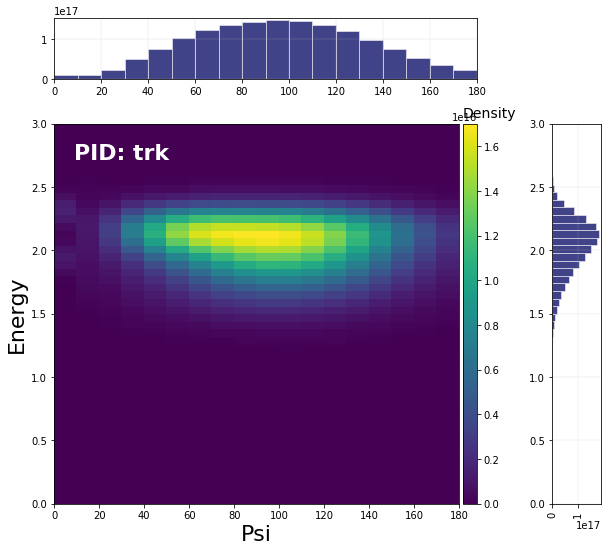

In [65]:
RecoRate = np.tensordot(Resp, Rate['nu_mu'], axes=([0,1], [0,1]))
plot_projections(RecoRate, np.array([Psireco_edges, np.log10(Ereco_edges)]), "Psi", "Energy", "PID: trk")


TypeError: unsupported operand type(s) for /: 'list' and 'float'

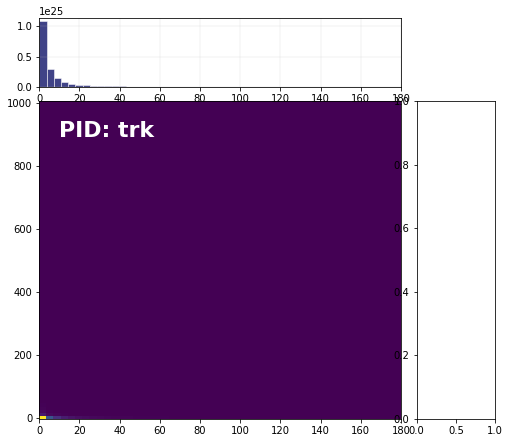

In [12]:
plot_projections(Rate['nu_mu'], np.array([Psitrue_edges, Etrue_edges]), "Psi", "Energy", "PID: trk")

In [13]:
Etrue_center

array([   1.        ,   11.09090909,   21.18181818,   31.27272727,
         41.36363636,   51.45454545,   61.54545455,   71.63636364,
         81.72727273,   91.81818182,  101.90909091,  112.        ,
        122.09090909,  132.18181818,  142.27272727,  152.36363636,
        162.45454545,  172.54545455,  182.63636364,  192.72727273,
        202.81818182,  212.90909091,  223.        ,  233.09090909,
        243.18181818,  253.27272727,  263.36363636,  273.45454545,
        283.54545455,  293.63636364,  303.72727273,  313.81818182,
        323.90909091,  334.        ,  344.09090909,  354.18181818,
        364.27272727,  374.36363636,  384.45454545,  394.54545455,
        404.63636364,  414.72727273,  424.81818182,  434.90909091,
        445.        ,  455.09090909,  465.18181818,  475.27272727,
        485.36363636,  495.45454545,  505.54545455,  515.63636364,
        525.72727273,  535.81818182,  545.90909091,  556.        ,
        566.09090909,  576.18181818,  586.27272727,  596.36363

In [14]:
Resp.shape

(50, 100, 18, 50)

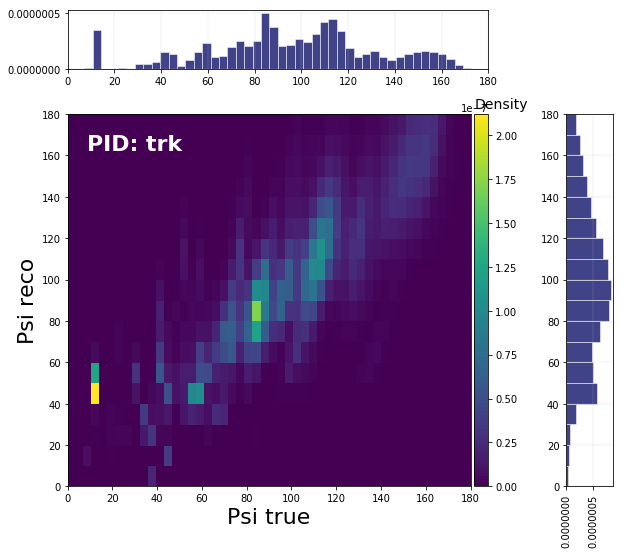

In [13]:
# plot_projections(np.log(Resp[0:50, 34, 0:18, 24]), np.array([Psitrue_edges, Psireco_edges]), "Psi true", "Psi reco", "PID: trk", norm=-10, min=-30)
plot_projections(Resp[0:50, 34, 0:18, 24], np.array([Psitrue_edges, Psireco_edges]), "Psi true", "Psi reco", "PID: trk")


In [14]:
MC = ExtractMC(['120000', '140000', '160000'])

In [17]:
np.max(MC['oneweight'])

4872926056.643208

In [17]:
wbin = np.linspace(0, 5e9, 100)
hw = np.histogram(MC['oneweight'], wbin)

[]

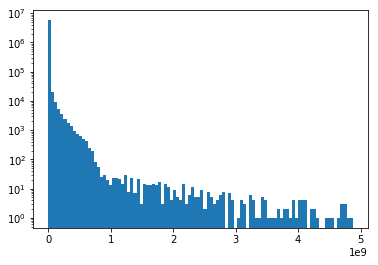

In [12]:
plt.hist(MC['oneweight'], bins = 100)
plt.semilogy()
# plt.semilogx()

In [13]:
loc = np.where((MC['oneweight']>1e9))
loc2 = np.where((MC['oneweight']<=1e9))
psitrue_highW = MC["psi_true"][loc]
psireco_highW = MC["psi_reco"][loc]
highW = MC["oneweight"][loc]

psitrue_lowW = MC["psi_true"][loc2]
psireco_lowW = MC["psi_reco"][loc2]
lowW = MC["oneweight"][loc2]

In [14]:
histhigh = np.histogram2d(psitrue_highW,psireco_highW, 
            bins=(np.linspace(0,180, 50), np.linspace(0,180, 50)), weights=highW)

histlow = np.histogram2d(psitrue_lowW,psireco_lowW, 
            bins=(np.linspace(0,180, 50), np.linspace(0,180, 50)), weights=lowW)
edges = np.array(np.linspace(0,180, 50)) 

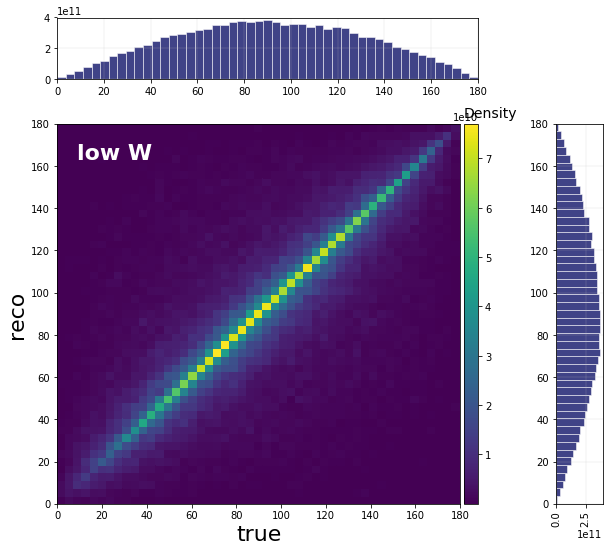

In [15]:
plot_projections(histlow[0], [edges, edges], x_label='true', y_label='reco', title='low W')

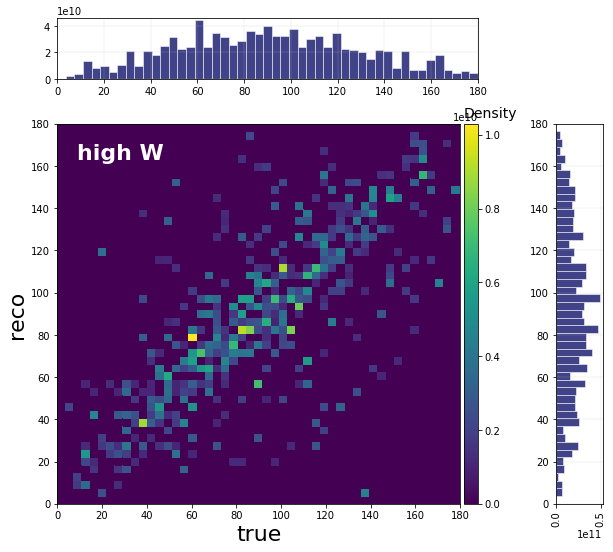

In [16]:
plot_projections(histhigh[0], [edges, edges], x_label='true', y_label='reco', title='high W')

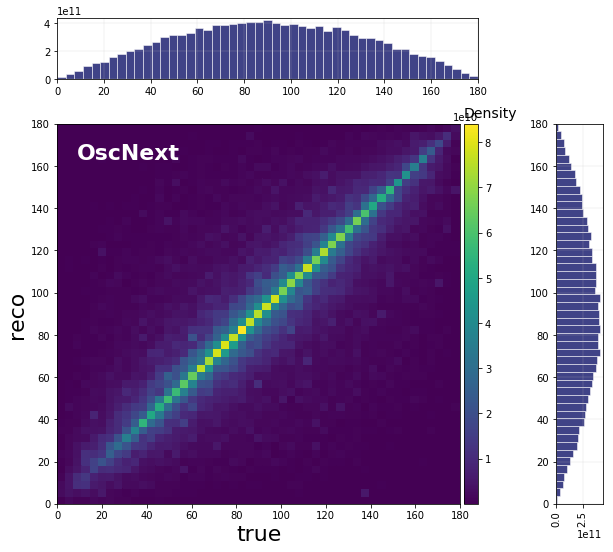

In [17]:
# nocut
hist = np.histogram2d(MC["psi_true"],MC["psi_reco"], 
            bins=(np.linspace(0,180, 50), np.linspace(0,180, 50)), weights=MC['oneweight'])

plot_projections(hist[0], [edges, np.linspace(0,180, 50)], x_label='true', y_label='reco', title='OscNext')

In [15]:
# Response matrix no kde:
Resp_bin = pkl.load(open("PreComp/ResponseMatrix_mass_1000.pkl", "rb"))
Resp_bin['nu_mu'].shape
RespBin = Resp_bin['nu_mu'][0:50, 0:100, 2, 0:18, 0:50]
RespBin.shape

(50, 100, 18, 50)

In [16]:
Resp.shape

(50, 100, 18, 50)

In [17]:
Resp_bin['Bin']['true_energy_center']

array([   1.        ,   11.09090909,   21.18181818,   31.27272727,
         41.36363636,   51.45454545,   61.54545455,   71.63636364,
         81.72727273,   91.81818182,  101.90909091,  112.        ,
        122.09090909,  132.18181818,  142.27272727,  152.36363636,
        162.45454545,  172.54545455,  182.63636364,  192.72727273,
        202.81818182,  212.90909091,  223.        ,  233.09090909,
        243.18181818,  253.27272727,  263.36363636,  273.45454545,
        283.54545455,  293.63636364,  303.72727273,  313.81818182,
        323.90909091,  334.        ,  344.09090909,  354.18181818,
        364.27272727,  374.36363636,  384.45454545,  394.54545455,
        404.63636364,  414.72727273,  424.81818182,  434.90909091,
        445.        ,  455.09090909,  465.18181818,  475.27272727,
        485.36363636,  495.45454545,  505.54545455,  515.63636364,
        525.72727273,  535.81818182,  545.90909091,  556.        ,
        566.09090909,  576.18181818,  586.27272727,  596.36363

In [18]:
Bin['true_energy_center']

array([   1.        ,   11.09090909,   21.18181818,   31.27272727,
         41.36363636,   51.45454545,   61.54545455,   71.63636364,
         81.72727273,   91.81818182,  101.90909091,  112.        ,
        122.09090909,  132.18181818,  142.27272727,  152.36363636,
        162.45454545,  172.54545455,  182.63636364,  192.72727273,
        202.81818182,  212.90909091,  223.        ,  233.09090909,
        243.18181818,  253.27272727,  263.36363636,  273.45454545,
        283.54545455,  293.63636364,  303.72727273,  313.81818182,
        323.90909091,  334.        ,  344.09090909,  354.18181818,
        364.27272727,  374.36363636,  384.45454545,  394.54545455,
        404.63636364,  414.72727273,  424.81818182,  434.90909091,
        445.        ,  455.09090909,  465.18181818,  475.27272727,
        485.36363636,  495.45454545,  505.54545455,  515.63636364,
        525.72727273,  535.81818182,  545.90909091,  556.        ,
        566.09090909,  576.18181818,  586.27272727,  596.36363

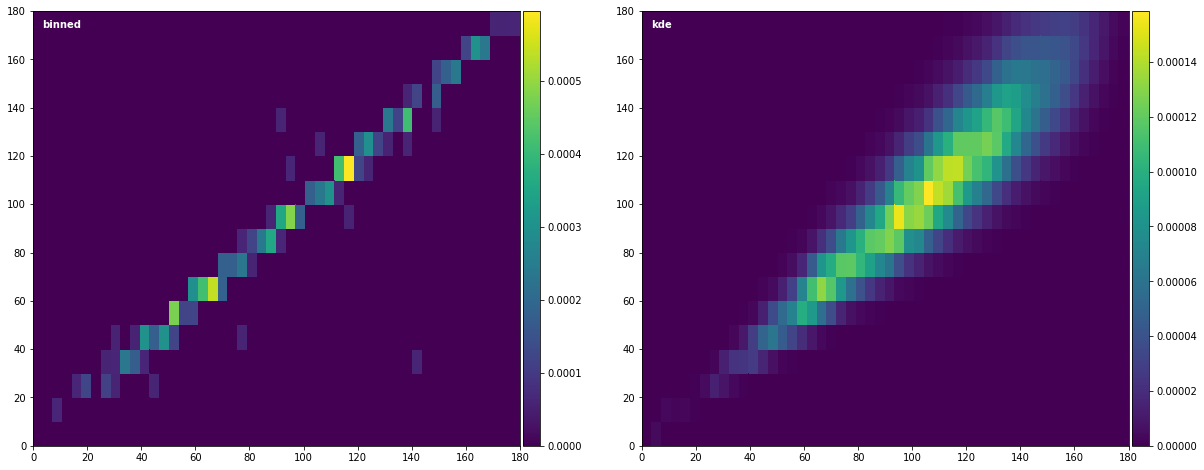

In [20]:
# Normalized both for comparison:
RespBin = RespBin/np.sum(RespBin)
Resp = Resp/np.sum(Resp)

# psires1 = RespBin[0:50, 50, 0:18, 27]
# psires2 = Resp[0:50, 50, 0:18, 27]
psires1 = np.zeros((50, 18))
psires2 = np.zeros((50, 18))
iEtrue = 50
for j in range(0, 50):
    psires1 += RespBin[0:50, iEtrue, 0:18, j]
    psires2 += Resp[0:50, iEtrue, 0:18, j]
Plot2D_sidebyside_noPID(psires1, psires2, [Bin['true_psi_edges'], Bin['reco_psi_edges']], title1='binned', title2='kde')

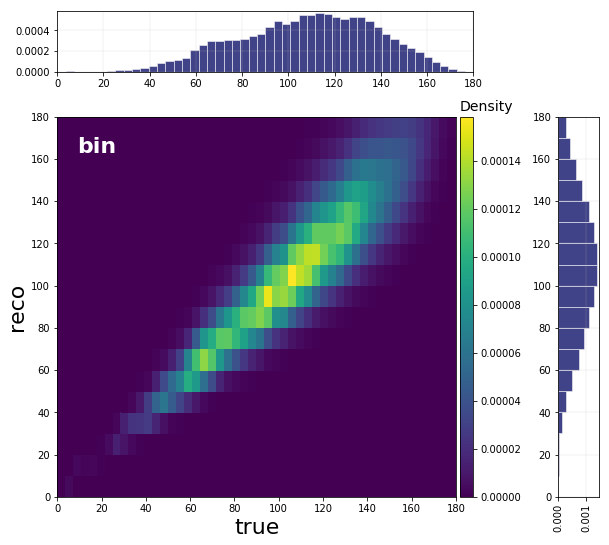

In [47]:
plot_projections(psires2, [Bin['true_psi_edges'], Bin['reco_psi_edges']], x_label='true', y_label='reco', title='bin')

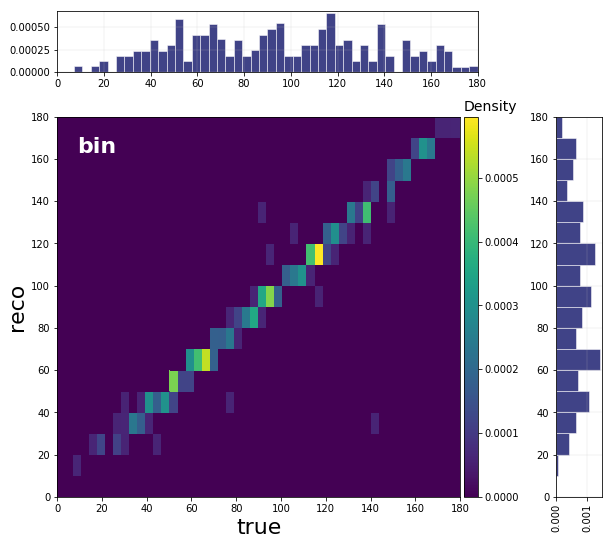

In [48]:
plot_projections(psires1, [Bin['true_psi_edges'], Bin['reco_psi_edges']], x_label='true', y_label='reco', title='bin')

In [22]:
psi_bin = np.zeros((50, 18))
psi_kde = np.zeros((50, 18))
for i in range(0, 100):
    for j in range(0, 50):
        psi_bin += RespBin[0:50, i, 0:18, j]
        psi_kde += Resp[0:50, i, 0:18, j]


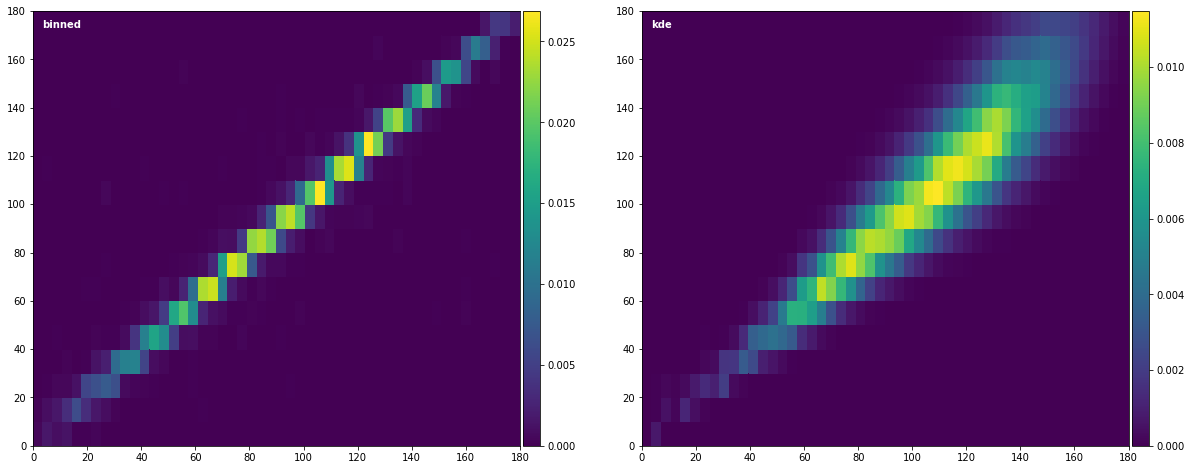

In [23]:
Plot2D_sidebyside_noPID(psi_bin, psi_kde, [Bin['true_psi_edges'], Bin['reco_psi_edges']], title1='binned', title2='kde')

In [24]:
E_bin = np.zeros((100, 50))
E_kde = np.zeros((100, 50))
for i in range(0, 50):
    for j in range(0, 18):
        E_bin += RespBin[i, 0:100, j, 0:50]
        E_kde += Resp[i, 0:100, j, 0:50]


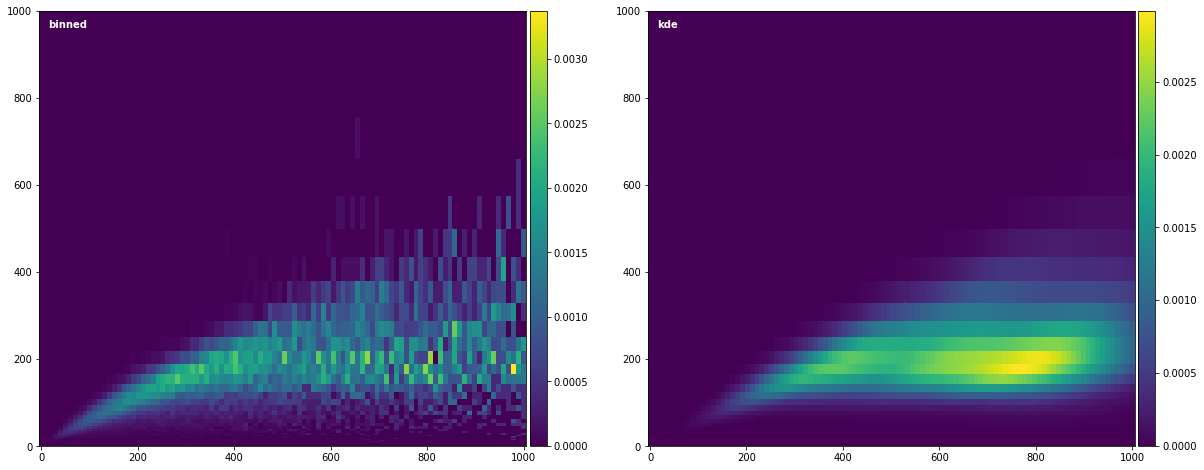

In [25]:
Plot2D_sidebyside_noPID(E_bin, E_kde, [Bin['true_energy_edges'], Bin['reco_energy_edges']], title1='binned', title2='kde')

In [26]:
# Extract precompute spectra
pathSpectra="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/Spectra_ann_Charon_atEarth_nocut.pkl"

# Precomputed Jfactor:
pathJfactor="/data/user/tchau/Sandbox/GC_OscNext/Spectra/PreComp/JFactor_NFW.pkl"
# True spectra:
Jfactor = Interpolate_Jfactor(pathJfactor, Psitrue_center)
# Spectra:
Spectra = Interpolate_Spectra(pathSpectra, Etrue_center, "bb", 1000)


# Compute the rate as Spectra x Jfactor
Rate = TrueRate(Spectra, Jfactor)
Rate['nu_mu'].shape

Detect_bin = np.tensordot(Rate['nu_mu'], RespBin, axes=([0,1], [0,1]))
Detect_kde = np.tensordot(Rate['nu_mu'], Resp, axes=([0,1], [0,1]))

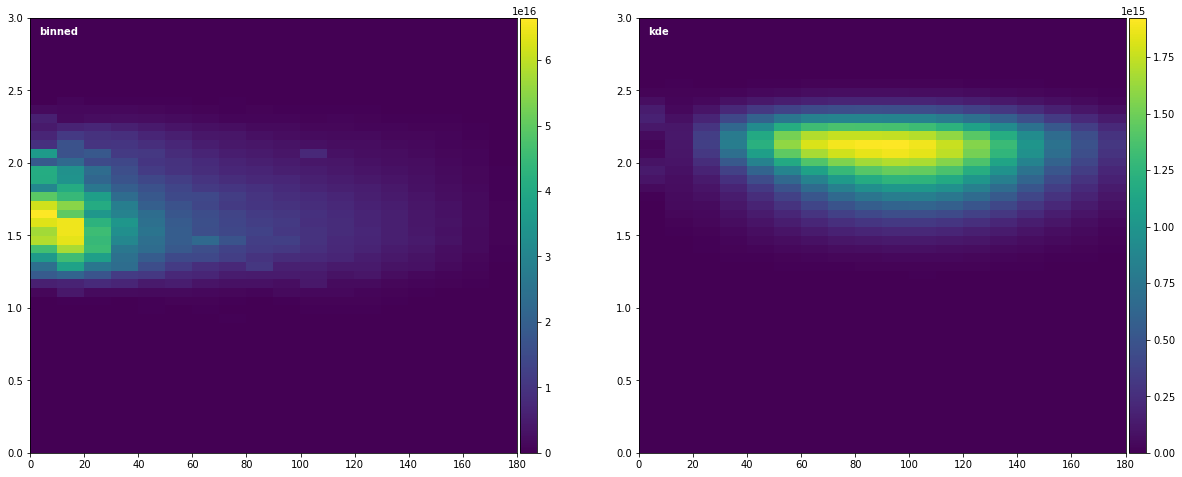

In [27]:
Plot2D_sidebyside_noPID(Detect_bin, Detect_kde, [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], title1='binned', title2='kde')

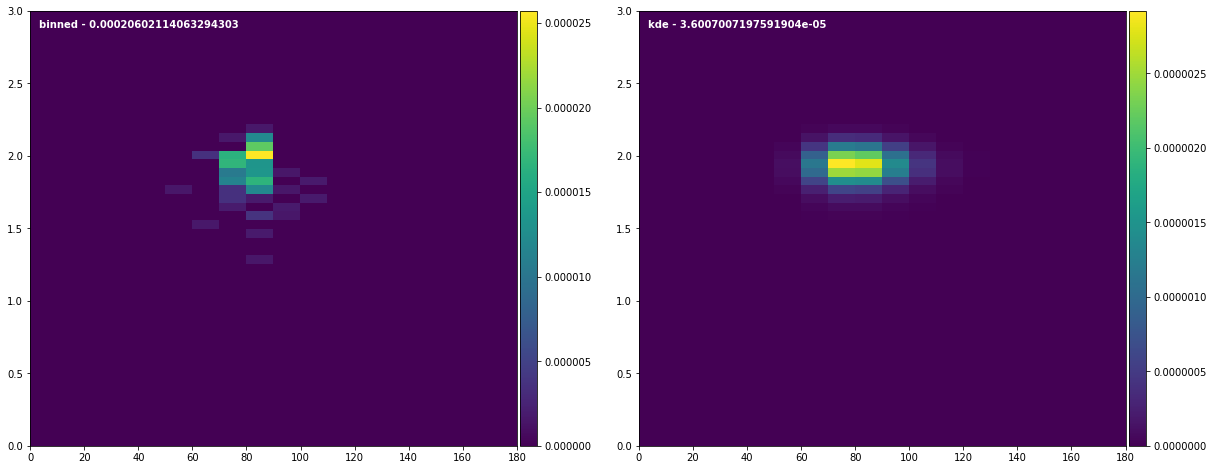

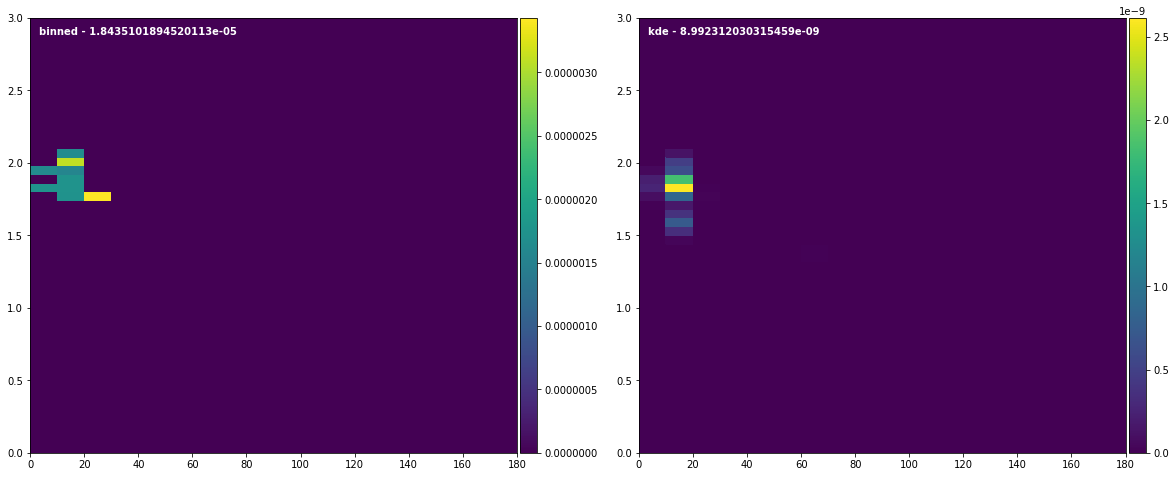

In [52]:
binned = RespBin[22, 15, 0:18, 0:50]
kde = Resp[22, 15, 0:18, 0:50]
Plot2D_sidebyside_noPID(binned, kde, [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], title1='binned - {}'.format(np.sum(binned)), title2='kde - {}'.format(np.sum(kde)))
binned = RespBin[2, 15, 0:18, 0:50]
kde = Resp[2, 15, 0:18, 0:50]
Plot2D_sidebyside_noPID(binned, kde, [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], title1='binned - {}'.format(np.sum(binned)), title2='kde - {}'.format(np.sum(kde)))

In [33]:
# Cut the binned response matrix for each energy and try the concatenate axis 1 gain to check:
resp_temp = np.zeros((50, 50, 2, 18, 50))
for i in range(0, 99, 2):
    resp_temp[int(i/2)] = RespBin[0:50, i:i+2, 0:18, 0:50]

# put a gain by concatenate:
for j in range(0, 50):
    if j==0:
        RespBin2 = resp_temp[j] 
    else:
        RespBin2 = np.concatenate((RespBin2, resp_temp[j]), axis=1)

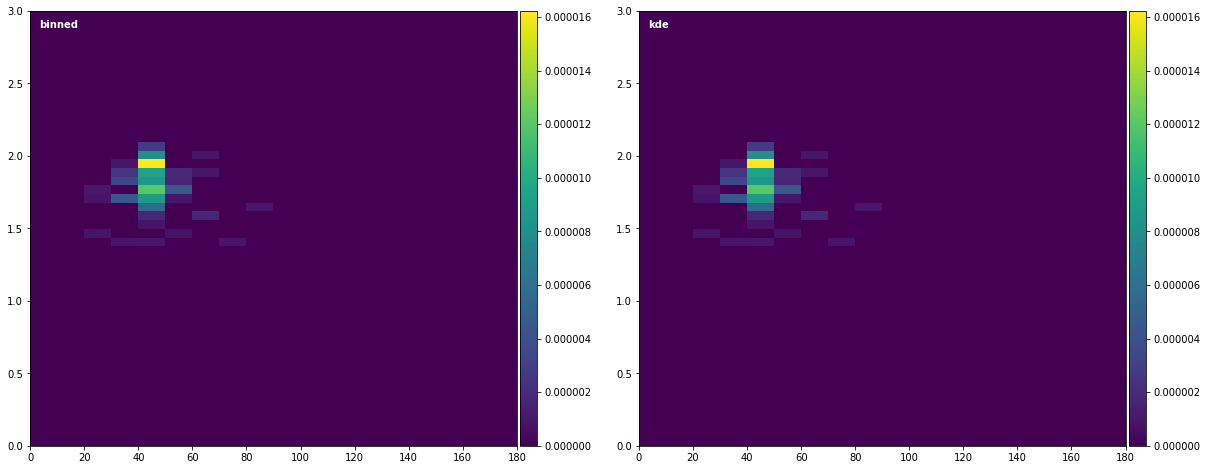

In [50]:
Plot2D_sidebyside_noPID(RespBin[12, 12, 0:18, 0:50], RespBin2[12, 12, 0:18, 0:50], [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], title1='binned', title2='kde')

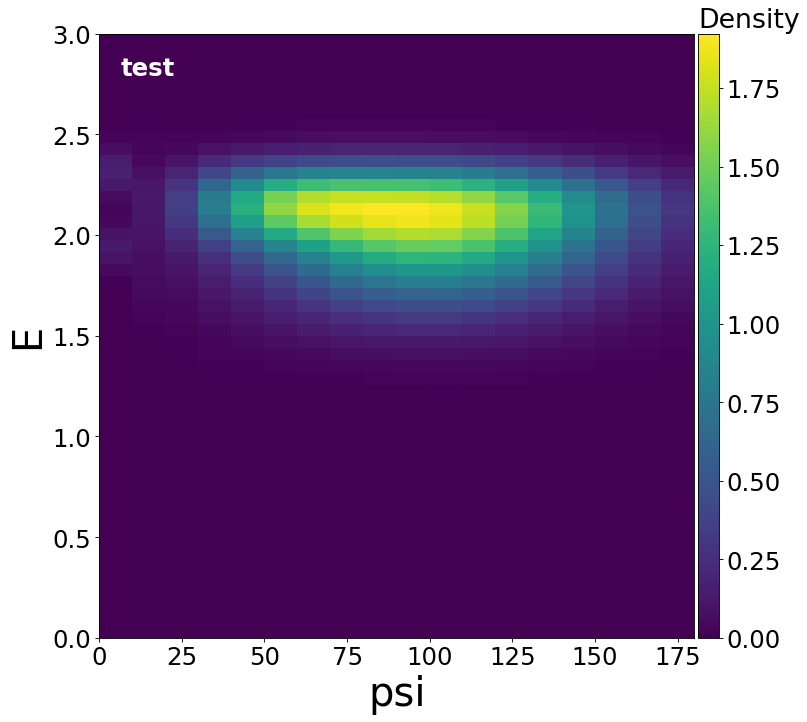

In [36]:
rate2 = np.tensordot(Rate['nu_mu'], Resp, axes=([0,1], [0,1]))
plot_2DHist(rate2, [Bin['reco_psi_edges'], np.log10(Bin['reco_energy_edges'])], x_label='psi', y_label='E', title='test')

0.00030142169989949645